In [1]:
from google.colab import files

uploaded = files.upload()

Saving reviews_dataset.csv to reviews_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
# Load dataset
df = pd.read_csv('reviews_dataset.csv')

# Define text preprocessing functions
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Apply text preprocessing
df['ReviewContent'] = df['ReviewContent'].apply(remove_punctuation)
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['ReviewContent'] = df['ReviewContent'].apply(remove_stopwords)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['ReviewContent'] = df['ReviewContent'].apply(lemmatize_text)

# Encode categorical variables
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])
df['Generation_encoded'] = label_encoder.fit_transform(df['Generation'])
df['Sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])
df['Country_encoded'] = label_encoder.fit_transform(df['Country'])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
# Define features and target variable
X = df['ReviewContent']
y = df['Sentiment_encoded']

# Stratified split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Analyze the length distribution of the sequences
review_lengths = [len(seq) for seq in X_train_seq]

# Set max_len based on the 100th percentile length (longest review)
max_len = np.percentile(review_lengths, 100).astype(int)  # Use 100th percentile length

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

embedding_dim = 256

model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_cnn.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    epochs=18,  # Adjust epochs as needed
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 468, 256)          1280000   
                                                                 
 conv1d_4 (Conv1D)           (None, 464, 128)          163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 92, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 88, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 128)              

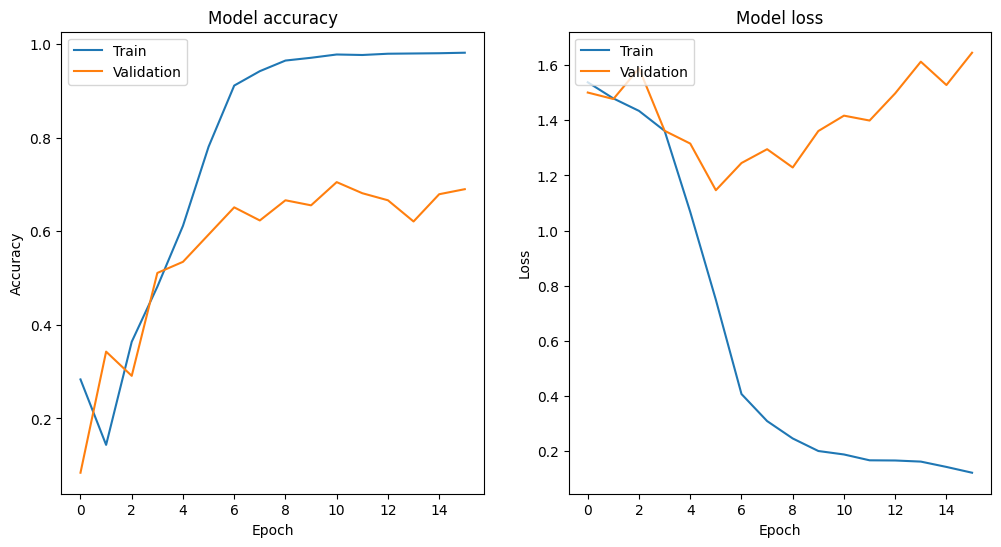

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
# Evaluate the model
y_pred_cnn = model_cnn.predict(X_test_pad)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Classification report
print("Classification Report (CNN):")
print(classification_report(y_test, y_pred_classes_cnn))

# Accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_classes_cnn)
print(f"Accuracy (CNN): {accuracy_cnn:.2f}")

32/32 [==============================] - 3s 96ms/step
Classification Report (CNN):
              precision    recall  f1-score   support

           0       0.28      0.46      0.35       125
           1       0.14      0.15      0.14        53
           2       0.55      0.32      0.40       117
           3       0.78      0.75      0.77       698

    accuracy                           0.63       993
   macro avg       0.44      0.42      0.42       993
weighted avg       0.66      0.63      0.64       993

Accuracy (CNN): 0.63
